# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import glob
from matplotlib.dates import drange
import matplotlib.dates as mdates
import os
import random
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.utils import shuffle
import copy
from torch.cuda import amp

In [ ]:
# Additional dataset is needed here. Population predictions that are used for calculating mb density from active. 
# /kaggle/input/census-data-for-godaddy/

# Config

In [2]:
class cfg:
    local = False
    testing = False

In [3]:
if cfg.local:
    data_dir = '../../data/original_data_updated'
    prepared_data_dir = '../../data/prepared_data'
    model_dir = '../../data/models'
else:
    data_dir = '/kaggle/input/godaddy-microbusiness-density-forecasting'
    prepared_data_dir = '/kaggle/input/microbusiness-prepare-data-active-1/prepared_data'
    model_dir = '/kaggle/input/microbusiness-model-3-active'

file_paths = {
    'train': f'{data_dir}/train.csv',
    'test': f'{data_dir}/test.csv',
    'census_starter': f'{data_dir}/census_starter.csv',
    'sample_submission': f'{data_dir}/sample_submission.csv',

    'train_splits': glob.glob(f'{prepared_data_dir}/train/train_*.parquet'),
    'val_splits': glob.glob(f'{prepared_data_dir}/val/val_*.parquet'),
    'test_splits': glob.glob(f'{prepared_data_dir}/test/test_*.parquet'),

    'last_model_epoch': f'{model_dir}/torch_model_last_epoch_wts_1.bin',
    
    'best_model_epoch': '/kaggle/input/microbusiness-model-3-active/cpu_kaggle_model_4_2023-03-14.bin',
}

file_paths['train_splits'].sort()
file_paths['val_splits'].sort()
file_paths['test_splits'].sort()
file_paths

{'train': '/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv',
 'test': '/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv',
 'census_starter': '/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv',
 'sample_submission': '/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv',
 'train_splits': ['/kaggle/input/microbusiness-prepare-data-active-1/prepared_data/train/train_0.parquet',
  '/kaggle/input/microbusiness-prepare-data-active-1/prepared_data/train/train_1.parquet',
  '/kaggle/input/microbusiness-prepare-data-active-1/prepared_data/train/train_2.parquet',
  '/kaggle/input/microbusiness-prepare-data-active-1/prepared_data/train/train_3.parquet',
  '/kaggle/input/microbusiness-prepare-data-active-1/prepared_data/train/train_4.parquet'],
 'val_splits': ['/kaggle/input/microbusiness-prepare-data-active-1/prepared_data/val/val_0.parquet',
  '/kaggle/input/microbusiness-prepare-data-active-1/prepared_data/val/

In [4]:
if cfg.local:
    save_dir = '.'
else:
    save_dir = '/kaggle/working'

file_paths_save = {
    'submission': save_dir + '/submission.csv'
}

# Load model

In [5]:
target_cols = [
    'active_4',
    'active_3',
    'active_2',
    'active_1',
    'active_0',
]

In [6]:
feature_cols = [

    'active_5', 'active_6', 'active_7', 'active_8', 'active_9', 'active_10', 'active_11', 'active_12',

    'county_code', 
    'state_code',

    'mean_12', 'median_12', 'mean_med_diff_12', 
    'min_12', 'max_12', 

    'last_1_diff', 'last_2_diff', 'last_3_diff', 'last_4_diff', 
    'last_5_diff', 'last_6_diff', 'last_7_diff', 'last_8_diff', 
    'last_9_diff', 'last_10_diff', 'last_11_diff', 'last_12_diff',

    'max_diff_12', 'min_diff_12', 'median_diff_12', 'mean_diff_12', 

    'last_1_diff_perc', 'last_2_diff_perc', 'last_3_diff_perc', 'last_4_diff_perc', 
    'last_5_diff_perc', 'last_6_diff_perc', 'last_7_diff_perc', 'last_8_diff_perc', 
    'last_9_diff_perc', 'last_10_diff_perc', 'last_11_diff_perc', 'last_12_diff_perc',

    'max_diff_perc_12', 'min_diff_perc_12', 'median_diff_perc_12', 'mean_diff_perc_12', 

    'population_range', 'population_change', 
    
    'lng', 'lat',
    
    'DIVISION',
]

In [7]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(len(feature_cols), 512, bias=False)
        self.fc2 = nn.Linear(512, 128, bias=False)
#         self.dr2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(128, 18, bias=False)
        # self.dr3 = nn.Dropout(0.1)
        self.fc4 = nn.Linear(18, len(target_cols), bias=False)
        # self.dr4 = nn.Dropout(0.1)

        self.af1 = nn.ELU()
        self.af2 = nn.LeakyReLU()
        self.af3 = nn.LeakyReLU()
        self.af4 = nn.LeakyReLU()


    def forward(self, inputs):
        x = inputs

        x = self.fc1(x)
        x = self.af1(x)

        x = self.fc2(x)
#         x = self.dr2(x)
        x = self.af2(x)

        x = self.fc3(x)
        # x = self.dr3(x)
        x = self.af3(x)
        
        x = self.fc4(x)
        x = self.af4(x)

        return x

In [8]:
model = Net()
model.to('cpu')
model.load_state_dict(torch.load(file_paths['best_model_epoch']))
model.eval()

Net(
  (fc1): Linear(in_features=52, out_features=512, bias=False)
  (fc2): Linear(in_features=512, out_features=128, bias=False)
  (fc3): Linear(in_features=128, out_features=18, bias=False)
  (fc4): Linear(in_features=18, out_features=5, bias=False)
  (af1): ELU(alpha=1.0)
  (af2): LeakyReLU(negative_slope=0.01)
  (af3): LeakyReLU(negative_slope=0.01)
  (af4): LeakyReLU(negative_slope=0.01)
)

# Helpers

In [9]:
def plot_preds_active(preds, true_df, cfips_li=[1001, 1003, 1005, 1007]):
    preds_df = pd.DataFrame(preds)
    preds_df.columns = [c+'_pred' for c in target_cols]
    preds_df['cfips'] = true_df['cfips'].copy()
    preds_df = preds_df.melt(id_vars='cfips', var_name='months_distance', value_name='active')
    preds_df.months_distance = preds_df.months_distance.apply(lambda x: int(x.split('_')[1]))
    preds_df = preds_df.sort_values('months_distance', ascending=True)

    cols = [c for c in true_df.columns if 'active_' in c]
    cols.append('cfips')
    tmp = true_df[cols].copy()
    tmp = tmp.melt(id_vars='cfips', var_name='months_distance', value_name='active')
    tmp.months_distance = tmp.months_distance.apply(lambda x: int(x.split('_')[1]))
    tmp = tmp.sort_values('months_distance', ascending=True)

    preds_df = pd.concat([preds_df, tmp.loc[tmp.months_distance > 4]], axis=0)

    figure, axis = plt.subplots(1, 4, figsize=(20,4), squeeze=True)
    for i,one_cfips in enumerate(cfips_li):
        ax = axis[i%4]
        ax.plot(tmp.loc[tmp.cfips==one_cfips].months_distance, tmp.loc[tmp.cfips==one_cfips].active, 'b-')
        ax.plot(preds_df.loc[preds_df.cfips==one_cfips].months_distance, preds_df.loc[preds_df.cfips==one_cfips].active, 'r-')
        ax.set_title(one_cfips)
        ax.invert_xaxis()
        ax.grid()
    plt.show()
def plot_preds(preds, true_df, cfips_li=[1001, 1003, 1005, 1007]):
    preds_df = pd.DataFrame(preds)
    preds_df.columns = [c+'_pred' for c in target_cols]
    preds_df['cfips'] = true_df['cfips'].copy()
    preds_df = preds_df.melt(id_vars='cfips', var_name='months_distance', value_name='microbusiness_density')
    preds_df.months_distance = preds_df.months_distance.apply(lambda x: int(x.split('_')[2]))
    preds_df = preds_df.sort_values('months_distance', ascending=True)

    cols = [c for c in true_df.columns if 'mb_density_' in c]
    cols.append('cfips')
    tmp = true_df[cols].copy()
    tmp = tmp.melt(id_vars='cfips', var_name='months_distance', value_name='microbusiness_density')
    tmp.months_distance = tmp.months_distance.apply(lambda x: int(x.split('_')[2]))
    tmp = tmp.sort_values('months_distance', ascending=True)

    preds_df = pd.concat([preds_df, tmp.loc[tmp.months_distance > 4]], axis=0)

    figure, axis = plt.subplots(1, 4, figsize=(20,4), squeeze=True)
    for i,one_cfips in enumerate(cfips_li):
        ax = axis[i%4]
        ax.plot(tmp.loc[tmp.cfips==one_cfips].months_distance, tmp.loc[tmp.cfips==one_cfips].microbusiness_density, 'b-')
        ax.plot(preds_df.loc[preds_df.cfips==one_cfips].months_distance, preds_df.loc[preds_df.cfips==one_cfips].microbusiness_density, 'r-')
        ax.set_title(one_cfips)
        ax.invert_xaxis()
        ax.grid()
    plt.show()
def get_preds_df(preds, true_df, months=[0,1,2,3,4]):

    pred_cols = [c+'_pred' for c in target_cols]
    tmp = pd.DataFrame(preds)
    tmp.columns = pred_cols

    preds_df = true_df[['cfips'] + target_cols]
    preds_df = pd.concat([preds_df, tmp], axis=1)
    return preds_df

def calc_smape_active(preds, true_df, months=[0,1,2,3,4]):
    pred_cols = [c+'_pred' for c in target_cols]
    tmp = pd.DataFrame(preds)
    tmp.columns = pred_cols

    preds_df = true_df[['cfips'] + target_cols]
    preds_df = pd.concat([preds_df, tmp], axis=1)
    # display(preds_df)

    return symmetric_mean_abs_perc_err_active(preds_df, months)
def symmetric_mean_abs_perc_err_active(preds_df, months=[0,1,2,3,4]):
    smape = np.zeros(len(months))
    for i, m in enumerate(months):
        smape[i] = 100.0 * np.mean(
            2.0
            * np.abs(preds_df[f'active_{m}'] - preds_df[f'active_{m}_pred']) 
            / (np.abs(preds_df[f'active_{m}']) + np.abs(preds_df[f'active_{m}_pred']))
        )

    return np.mean(smape)
def smape(preds_npy, true_npy):
    return 100.0 * np.mean(
        2.0
        * np.abs(preds_npy - true_npy) 
        / (np.abs(preds_npy) + np.abs(true_npy))
    )

def smape_torch(preds_tensor, true_tensor):
    return 100.0 * torch.mean(
        2.0
        * torch.abs(preds_tensor - true_tensor) 
        / (torch.abs(preds_tensor) + torch.abs(true_tensor) + 1e-9)
    )

# Evaluate model

In [10]:
def log_to_file(line, end='\n'):
    # if cfg.local:
    with open('./scores_log.md', "a") as scores_log_file:
        scores_log_file.writelines(line + end)
def format_num(x):
    dec_points = 4
    total_chars_taken = 8
    # total_chars_in_str = 8
    return f'{str(round(x, dec_points))[:total_chars_taken]:8}'

In [11]:
# Evaluate the model
print('Train splits')
log_to_file('Train splits ' + datetime.datetime.now().isoformat(timespec='minutes'))

model.eval()
for split in range(5):
    split_log_result = ['Split', split, ' | ']
    eval_df = pd.read_parquet(file_paths['train_splits'][split])
    x_np = eval_df[feature_cols].to_numpy().reshape(len(eval_df), len(feature_cols))
    y_np = eval_df[target_cols].to_numpy().reshape(len(eval_df), len(target_cols))

    x_tensor = Variable(torch.FloatTensor(x_np), requires_grad=True)
    with torch.no_grad():
        val_preds = model(x_tensor)

    y_tensor = Variable(torch.FloatTensor(y_np))
    split_log_result += [format_num(smape_torch(val_preds, y_tensor).item()), ' | ']
    for month in range(len(target_cols)):
        tmp = calc_smape_active(val_preds.detach().numpy(), eval_df, months=[4-month])
        split_log_result += [format_num(tmp)]
        del tmp
        line = ' '.join([str(x) for x in split_log_result])
    print(line)
    log_to_file(line)
    # print()

Train splits
Split 0  |  2.5187    |  1.4315   2.0711   2.4003   2.933    3.7576  
Split 1  |  2.4625    |  1.341    2.0142   2.6063   2.9359   3.4152  
Split 2  |  2.3605    |  1.2341   1.8442   2.4587   2.9793   3.2862  
Split 3  |  2.3347    |  1.3069   1.8239   2.3146   2.8589   3.3691  
Split 4  |  2.5665    |  1.7749   2.1762   2.5355   2.9137   3.4323  


In [12]:
# Evaluate the model
print('Val splits')
log_to_file('Val splits ' + datetime.datetime.now().isoformat(timespec='minutes'))

model.eval()
for split in range(5):
    split_log_result = ['Split', split, ' | ']
    eval_df = pd.read_parquet(file_paths['val_splits'][split])
    x_np = eval_df[feature_cols].to_numpy().reshape(len(eval_df), len(feature_cols))
    y_np = eval_df[target_cols].to_numpy().reshape(len(eval_df), len(target_cols))

    x_tensor = Variable(torch.FloatTensor(x_np), requires_grad=True)
    with torch.no_grad():
        val_preds = model(x_tensor)

    y_tensor = Variable(torch.FloatTensor(y_np))
    split_log_result += [format_num(smape_torch(val_preds, y_tensor).item()), ' | ']
    for month in range(len(target_cols)):
        tmp = calc_smape_active(val_preds.detach().numpy(), eval_df, months=[4-month])
        split_log_result += [format_num(tmp)]
        del tmp
        line = ' '.join([str(x) for x in split_log_result])
    print(line)
    log_to_file(line)

Val splits
Split 0  |  2.6444    |  1.5852   2.1304   2.6157   3.1012   3.7898  
Split 1  |  2.5738    |  2.1486   1.9489   2.5009   2.9434   3.3274  
Split 2  |  2.7602    |  1.4808   2.884    2.6934   3.1889   3.5539  
Split 3  |  2.3949    |  1.2447   1.8649   2.7563   2.8141   3.2946  
Split 4  |  2.4393    |  1.3687   1.9238   2.4362   3.1924   3.2755  


# Create prediction

In [13]:
test_df = pd.read_csv(file_paths['test'])

In [14]:
test_split_df = pd.read_parquet(file_paths['test_splits'][0])
print(test_df.first_day_of_month.min(), test_df.first_day_of_month.max())

2022-11-01 2023-06-01


In [15]:
test_split_df.head(2)

,cfips,mb_density_0,mb_density_1,mb_density_2,mb_density_3,mb_density_4,mb_density_5,mb_density_6,mb_density_7,mb_density_8,...,INTERNATIONALMIG_diff_perc_2020,INTERNATIONALMIG_diff_perc_2021,DOMESTICMIG_diff_perc_2020,DOMESTICMIG_diff_perc_2021,NETMIG_diff_perc_2020,NETMIG_diff_perc_2021,RESIDUAL_diff_perc_2020,RESIDUAL_diff_perc_2021,GQESTIMATES_diff_perc_2020,GQESTIMATES_diff_perc_2021
0,1001,-1.0,-1.0,-1.0,-1.0,-1.0,3.470915,3.442677,3.463856,3.442677,...,10.0,-1.000000,1.443299,-0.590717,1.494845,-0.599174,10.000000,-1.000000,-2.262444e-09,-2.262444e-09
1,1003,-1.0,-1.0,-1.0,-1.0,-1.0,8.250630,8.257636,8.359798,8.341701,...,-10.0,-1.015873,3.472296,-0.776401,3.516832,-0.778606,9.250001,-0.902439,-4.593477e-10,-4.593477e-10


In [16]:
model.eval()
split = 0
print('Split', split, end=' | ')

test_split_df = pd.read_parquet(file_paths['test_splits'][split])

x_test_np = test_split_df[feature_cols].to_numpy().reshape(len(test_split_df), len(feature_cols))
y_test_np = test_split_df[target_cols].to_numpy().reshape(len(test_split_df), len(target_cols))
print(x_test_np.shape, y_test_np.shape)

x_test_var = torch.tensor(x_test_np)
with torch.no_grad():
    test_preds = model(x_test_var)

pred_cols = [c+'_pred' for c in target_cols]
tmp = pd.DataFrame(test_preds.detach().numpy())
tmp.columns = pred_cols

preds_df = test_split_df[['cfips']]
preds_df = pd.concat([preds_df, tmp], axis=1)

Split 0 | (3135, 52) (3135, 5)


In [17]:
preds_df

,cfips,active_4_pred,active_3_pred,active_2_pred,active_1_pred,active_0_pred
0,1001,1.487537,1.491530,1.496074,1.500576,1.504767
1,1003,14.251685,14.302272,14.361685,14.415218,14.464823
2,1005,0.252303,0.253072,0.253755,0.254552,0.255332
3,1007,0.231036,0.231826,0.232463,0.233218,0.233933
4,1009,0.830284,0.832497,0.834799,0.837271,0.839422
...,...,...,...,...,...,...
3130,56037,0.921904,0.924336,0.926773,0.929466,0.931846
3131,56039,5.061916,5.078152,5.096691,5.114230,5.130566
3132,56041,0.589022,0.590489,0.592074,0.593787,0.595314
3133,56043,0.184655,0.185225,0.185764,0.186524,0.187045


# Active to density

In [18]:
def get_population_size_df():
    if cfg.local:
        return pd.read_parquet('../../data/other_data/population_sizes.parquet')
    else:
        cfips_df = test_split_df[['cfips']].copy()
        
        COLS = ['GEO_ID','NAME','S0101_C01_026E']
        df2020 = pd.read_csv('/kaggle/input/census-data-for-godaddy/ACSST5Y2020.S0101-Data.csv',usecols=COLS)
        df2020 = df2020.iloc[1:]
        df2020['S0101_C01_026E'] = df2020['S0101_C01_026E'].astype('int')

        df2021 = pd.read_csv('/kaggle/input/census-data-for-godaddy/ACSST5Y2021.S0101-Data.csv',usecols=COLS)
        df2021 = df2021.iloc[1:]
        df2021['S0101_C01_026E'] = df2021['S0101_C01_026E'].astype('int')

        df2020['cfips'] = df2020.GEO_ID.apply(lambda x: int(x.split('US')[-1]) )
        adult2020 = df2020.set_index('cfips').S0101_C01_026E.to_dict()

        df2021['cfips'] = df2021.GEO_ID.apply(lambda x: int(x.split('US')[-1]) )
        adult2021 = df2021.set_index('cfips').S0101_C01_026E.to_dict()

        cfips_df['adult2020'] = cfips_df.cfips.map(adult2020)
        cfips_df['adult2021'] = cfips_df.cfips.map(adult2021)
        
        return cfips_df

In [19]:
population_df = get_population_size_df()
population_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (102) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


,cfips,adult2020,adult2021
0,1001,42496,44438
1,1003,171296,178105
2,1005,19804,19995
3,1007,17790,17800
4,1009,44383,45201


In [20]:
target_cols

['active_4', 'active_3', 'active_2', 'active_1', 'active_0']

In [21]:
test_split_df

,cfips,mb_density_0,mb_density_1,mb_density_2,mb_density_3,mb_density_4,mb_density_5,mb_density_6,mb_density_7,mb_density_8,...,INTERNATIONALMIG_diff_perc_2020,INTERNATIONALMIG_diff_perc_2021,DOMESTICMIG_diff_perc_2020,DOMESTICMIG_diff_perc_2021,NETMIG_diff_perc_2020,NETMIG_diff_perc_2021,RESIDUAL_diff_perc_2020,RESIDUAL_diff_perc_2021,GQESTIMATES_diff_perc_2020,GQESTIMATES_diff_perc_2021
0,1001,-1.0,-1.0,-1.0,-1.0,-1.0,3.470915,3.442677,3.463856,3.442677,...,10.000000,-1.000000,1.443299,-0.590717,1.494845,-0.599174,1.000000e+01,-1.000000e+00,-2.262444e-09,-2.262444e-09
1,1003,-1.0,-1.0,-1.0,-1.0,-1.0,8.250630,8.257636,8.359798,8.341701,...,-10.000000,-1.015873,3.472296,-0.776401,3.516832,-0.778606,9.250001e+00,-9.024390e-01,-4.593477e-10,-4.593477e-10
2,1005,-1.0,-1.0,-1.0,-1.0,-1.0,1.252272,1.247223,1.232074,1.206827,...,10.000000,-1.000000,-10.000000,-1.030612,-10.000000,-1.030928,-2.000001e+00,-1.999999e+00,-3.585514e-10,-3.585514e-10
3,1007,-1.0,-1.0,-1.0,-1.0,-1.0,1.287240,1.275998,1.287240,1.315346,...,10.000000,-1.000000,-8.357143,-1.135922,-8.404762,-1.135048,-1.000000e+01,-1.000000e+00,-4.849660e-10,-4.849660e-10
4,1009,-1.0,-1.0,-1.0,-1.0,-1.0,1.852060,1.836289,1.831782,1.852060,...,10.000000,-1.000000,7.235294,-0.878571,7.352941,-0.880282,-5.500002e+00,-1.222222e+00,-2.227171e-09,-2.227171e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3130,56037,-1.0,-1.0,-1.0,-1.0,-1.0,2.876845,2.814440,2.823801,2.811320,...,10.000000,-0.944444,4.654867,-0.823161,4.544643,-0.819646,-2.999999e+00,-1.500000e+00,-1.388889e-09,-1.388889e-09
3131,56039,-1.0,-1.0,-1.0,-1.0,-1.0,26.314966,26.372364,26.273220,26.090586,...,2.999998,-0.750000,-10.000000,-1.021053,10.000000,-1.000000,-9.999990e-07,-9.999990e-07,-4.651163e-09,-4.651163e-09
3132,56041,-1.0,-1.0,-1.0,-1.0,-1.0,4.050703,4.016258,4.009369,3.995591,...,10.000000,-1.000000,-10.000000,-1.083969,-10.000000,-1.082090,-1.000000e+00,1.000000e+01,-5.347593e-09,-5.347593e-09
3133,56043,-1.0,-1.0,-1.0,-1.0,-1.0,3.060380,3.143093,3.126551,3.209264,...,-1.000000,-1.000000,-7.692308,-1.149425,-7.692308,-1.149425,-1.000000e+01,-1.000000e+00,-8.403362e-09,-8.403362e-09


In [23]:
test_split_df.mb_density_5.describe()

count    3135.000000
mean        4.036726
std         6.291807
min         0.094607
25%         1.718765
50%         2.703807
75%         4.707177
max       238.060425
Name: mb_density_5, dtype: float64

### Change values of low population counties

In [24]:
test_split_df.loc[test_split_df.population_range==0].mb_density_5.describe()

count    425.000000
mean       2.757574
std        3.819029
min        0.094607
25%        1.420248
50%        1.948775
75%        3.012048
max       65.426804
Name: mb_density_5, dtype: float64

In [25]:
# Chagne states with low population and low mb density prediction to same as before
cfips_to_change = test_split_df.loc[(test_split_df.population_range == 0)].cfips.unique()
# cfips_to_change = test_split_df.loc[(test_split_df.mb_density_5 < 1) & (test_split_df.population_range <= 1)].cfips.unique()
# print(len(cfips_to_change))
# cfips_to_change

# Add active 5 col to preds, but with empty rows for places that are not to be changed
preds_df = pd.merge(preds_df, test_split_df.loc[test_split_df.cfips.isin(cfips_to_change)][['cfips', 'active_5']], on='cfips', how='left')
# Fill empty fields with prediced values
preds_df.active_5 = preds_df.active_5.fillna(preds_df.active_4_pred)
# Rename and delete
preds_df.active_4_pred = preds_df.active_5
del preds_df['active_5']

preds_df.loc[preds_df.cfips.isin(cfips_to_change), 'active_3_pred'] = preds_df.active_4_pred
preds_df.loc[preds_df.cfips.isin(cfips_to_change), 'active_2_pred'] = preds_df.active_4_pred
preds_df.loc[preds_df.cfips.isin(cfips_to_change), 'active_1_pred'] = preds_df.active_4_pred
preds_df.loc[preds_df.cfips.isin(cfips_to_change), 'active_0_pred'] = preds_df.active_4_pred

In [26]:
preds_df

,cfips,active_4_pred,active_3_pred,active_2_pred,active_1_pred,active_0_pred
0,1001,1.487537,1.491530,1.496074,1.500576,1.504767
1,1003,14.251685,14.302272,14.361685,14.415218,14.464823
2,1005,0.252303,0.253072,0.253755,0.254552,0.255332
3,1007,0.231036,0.231826,0.232463,0.233218,0.233933
4,1009,0.830284,0.832497,0.834799,0.837271,0.839422
...,...,...,...,...,...,...
3130,56037,0.921904,0.924336,0.926773,0.929466,0.931846
3131,56039,5.061916,5.078152,5.096691,5.114230,5.130566
3132,56041,0.589022,0.590489,0.592074,0.593787,0.595314
3133,56043,0.184655,0.185225,0.185764,0.186524,0.187045


### Active to mb density

In [27]:
population_col = 'adult2021'
if cfg.testing:
    population_col = 'adult2020'
print(population_col)

preds_df['mb_density_4_pred'] = 100.0 * (1000.0 * preds_df['active_4_pred'] / population_df[population_col])
preds_df['mb_density_3_pred'] = 100.0 * (1000.0 * preds_df['active_3_pred'] / population_df[population_col])
preds_df['mb_density_2_pred'] = 100.0 * (1000.0 * preds_df['active_2_pred'] / population_df[population_col])
preds_df['mb_density_1_pred'] = 100.0 * (1000.0 * preds_df['active_1_pred'] / population_df[population_col])
preds_df['mb_density_0_pred'] = 100.0 * (1000.0 * preds_df['active_0_pred'] / population_df[population_col])

adult2021


In [28]:
preds_df

,cfips,active_4_pred,active_3_pred,active_2_pred,active_1_pred,active_0_pred,mb_density_4_pred,mb_density_3_pred,mb_density_2_pred,mb_density_1_pred,mb_density_0_pred
0,1001,1.487537,1.491530,1.496074,1.500576,1.504767,3.347444,3.356429,3.366654,3.376786,3.386218
1,1003,14.251685,14.302272,14.361685,14.415218,14.464823,8.001845,8.030247,8.063605,8.093663,8.121514
2,1005,0.252303,0.253072,0.253755,0.254552,0.255332,1.261828,1.265678,1.269092,1.273079,1.276980
3,1007,0.231036,0.231826,0.232463,0.233218,0.233933,1.297954,1.302396,1.305973,1.310212,1.314228
4,1009,0.830284,0.832497,0.834799,0.837271,0.839422,1.836871,1.841767,1.846860,1.852329,1.857088
...,...,...,...,...,...,...,...,...,...,...,...
3130,56037,0.921904,0.924336,0.926773,0.929466,0.931846,2.925379,2.933097,2.940829,2.949373,2.956926
3131,56039,5.061916,5.078152,5.096691,5.114230,5.130566,26.406784,26.491480,26.588194,26.679689,26.764909
3132,56041,0.589022,0.590489,0.592074,0.593787,0.595314,4.023096,4.033119,4.043944,4.055647,4.066072
3133,56043,0.184655,0.185225,0.185764,0.186524,0.187045,3.077586,3.087077,3.096061,3.108737,3.117424


# Create submission

In [29]:
preds_df

,cfips,active_4_pred,active_3_pred,active_2_pred,active_1_pred,active_0_pred,mb_density_4_pred,mb_density_3_pred,mb_density_2_pred,mb_density_1_pred,mb_density_0_pred
0,1001,1.487537,1.491530,1.496074,1.500576,1.504767,3.347444,3.356429,3.366654,3.376786,3.386218
1,1003,14.251685,14.302272,14.361685,14.415218,14.464823,8.001845,8.030247,8.063605,8.093663,8.121514
2,1005,0.252303,0.253072,0.253755,0.254552,0.255332,1.261828,1.265678,1.269092,1.273079,1.276980
3,1007,0.231036,0.231826,0.232463,0.233218,0.233933,1.297954,1.302396,1.305973,1.310212,1.314228
4,1009,0.830284,0.832497,0.834799,0.837271,0.839422,1.836871,1.841767,1.846860,1.852329,1.857088
...,...,...,...,...,...,...,...,...,...,...,...
3130,56037,0.921904,0.924336,0.926773,0.929466,0.931846,2.925379,2.933097,2.940829,2.949373,2.956926
3131,56039,5.061916,5.078152,5.096691,5.114230,5.130566,26.406784,26.491480,26.588194,26.679689,26.764909
3132,56041,0.589022,0.590489,0.592074,0.593787,0.595314,4.023096,4.033119,4.043944,4.055647,4.066072
3133,56043,0.184655,0.185225,0.185764,0.186524,0.187045,3.077586,3.087077,3.096061,3.108737,3.117424


In [30]:
sample_submission_df = pd.read_csv(file_paths['sample_submission'])
print(sample_submission_df.shape)
sample_submission_df.head()

(25080, 2)


,row_id,microbusiness_density
0,1001_2022-11-01,3.817671
1,1003_2022-11-01,3.817671
2,1005_2022-11-01,3.817671
3,1007_2022-11-01,3.817671
4,1009_2022-11-01,3.817671


In [31]:
sample_submission_df['first_day_of_month'] = sample_submission_df.row_id.apply(lambda x: ''.join(x.split('_')[1:]))
sample_submission_df.head()

,row_id,microbusiness_density,first_day_of_month
0,1001_2022-11-01,3.817671,2022-11-01
1,1003_2022-11-01,3.817671,2022-11-01
2,1005_2022-11-01,3.817671,2022-11-01
3,1007_2022-11-01,3.817671,2022-11-01
4,1009_2022-11-01,3.817671,2022-11-01


In [32]:
sample_submission_df.first_day_of_month.unique()

array(['2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01',
       '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01'],
      dtype=object)

In [33]:
tmp = preds_df[['cfips', 'mb_density_4_pred', 'mb_density_3_pred', 'mb_density_2_pred', 'mb_density_1_pred', 'mb_density_0_pred']].copy()
tmp = tmp.rename(columns={
    'mb_density_4_pred': '2023-01-01',
    'mb_density_3_pred': '2023-02-01',
    'mb_density_2_pred': '2023-03-01',
    'mb_density_1_pred': '2023-04-01',
    'mb_density_0_pred': '2023-05-01',
})

tmp['2022-11-01'] = tmp['2023-01-01']
tmp['2022-12-01'] = tmp['2023-01-01']
tmp['2023-06-01'] = tmp['2023-05-01']

print(tmp.shape)
display(tmp.head())

# tmp = preds_df.copy()
tmp = tmp.melt(id_vars='cfips', var_name='months_distance', value_name='microbusiness_density')

tmp = tmp.sort_values(['cfips', 'months_distance']).reset_index(drop=True)

print(tmp.shape)
display(tmp.head())

tmp['row_id'] = tmp['cfips'].astype(str) + '_' + tmp['months_distance'].astype(str)

print(tmp.shape)
display(tmp.head())

(3135, 9)


,cfips,2023-01-01,2023-02-01,2023-03-01,2023-04-01,2023-05-01,2022-11-01,2022-12-01,2023-06-01
0,1001,3.347444,3.356429,3.366654,3.376786,3.386218,3.347444,3.347444,3.386218
1,1003,8.001845,8.030247,8.063605,8.093663,8.121514,8.001845,8.001845,8.121514
2,1005,1.261828,1.265678,1.269092,1.273079,1.276980,1.261828,1.261828,1.276980
3,1007,1.297954,1.302396,1.305973,1.310212,1.314228,1.297954,1.297954,1.314228
4,1009,1.836871,1.841767,1.846860,1.852329,1.857088,1.836871,1.836871,1.857088


(25080, 3)


,cfips,months_distance,microbusiness_density
0,1001,2022-11-01,3.347444
1,1001,2022-12-01,3.347444
2,1001,2023-01-01,3.347444
3,1001,2023-02-01,3.356429
4,1001,2023-03-01,3.366654


(25080, 4)


,cfips,months_distance,microbusiness_density,row_id
0,1001,2022-11-01,3.347444,1001_2022-11-01
1,1001,2022-12-01,3.347444,1001_2022-12-01
2,1001,2023-01-01,3.347444,1001_2023-01-01
3,1001,2023-02-01,3.356429,1001_2023-02-01
4,1001,2023-03-01,3.366654,1001_2023-03-01


In [34]:
sample_submission_df = pd.read_csv(file_paths['sample_submission'])
submission_df = pd.merge(sample_submission_df[['row_id']], tmp[['row_id', 'microbusiness_density']], on='row_id')
submission_df

,row_id,microbusiness_density
0,1001_2022-11-01,3.347444
1,1003_2022-11-01,8.001845
2,1005_2022-11-01,1.261828
3,1007_2022-11-01,1.297954
4,1009_2022-11-01,1.836871
...,...,...
25075,56037_2023-06-01,2.956926
25076,56039_2023-06-01,26.764909
25077,56041_2023-06-01,4.066072
25078,56043_2023-06-01,3.117424


In [35]:
submission_df.to_csv(file_paths_save['submission'], index=False)

# Plot predictions

In [36]:
tmp_test_split_df = test_split_df.copy()
pred_cols = [c for c in target_cols]
for col in pred_cols:
    tmp_test_split_df[col] = tmp_test_split_df['active_5']
display(tmp_test_split_df.head(2)[[col for col in tmp_test_split_df.columns if 'active' in col]])

,active_0,active_1,active_2,active_3,active_4,active_5,active_6,active_7,active_8,active_9,...,active_22,active_23,active_24,active_25,active_26,active_27,active_28,active_29,active_30,active_31
0,1.475,1.475,1.475,1.475,1.475,1.475,1.463,1.472,1.463,1.455,...,1.354,1.359,1.361,1.360,1.326,1.310,1.243,1.256,1.271,1.336
1,14.133,14.133,14.133,14.133,14.133,14.133,14.145,14.320,14.289,14.545,...,13.301,13.456,13.430,13.382,13.291,13.176,13.346,13.359,13.422,13.529


[45087, 40125, 13237, 21101]


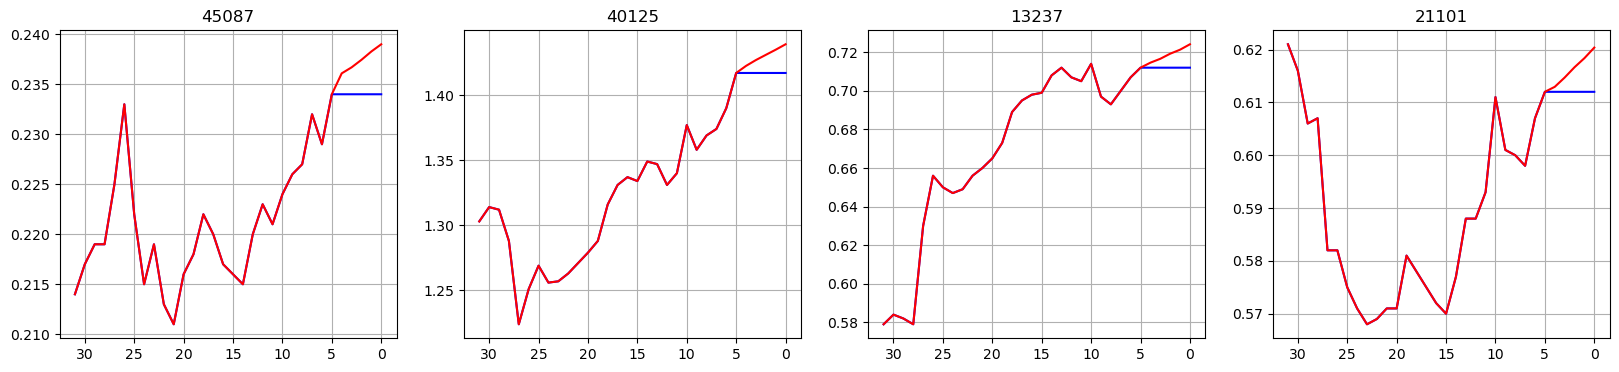

In [37]:
random_cfips = np.array(test_split_df.cfips.unique())
random_cfips = random_cfips[np.random.randint(0, len(random_cfips), size=4)]
print(random_cfips.tolist())
plot_preds_active(test_preds.detach().numpy(), tmp_test_split_df, random_cfips.tolist())

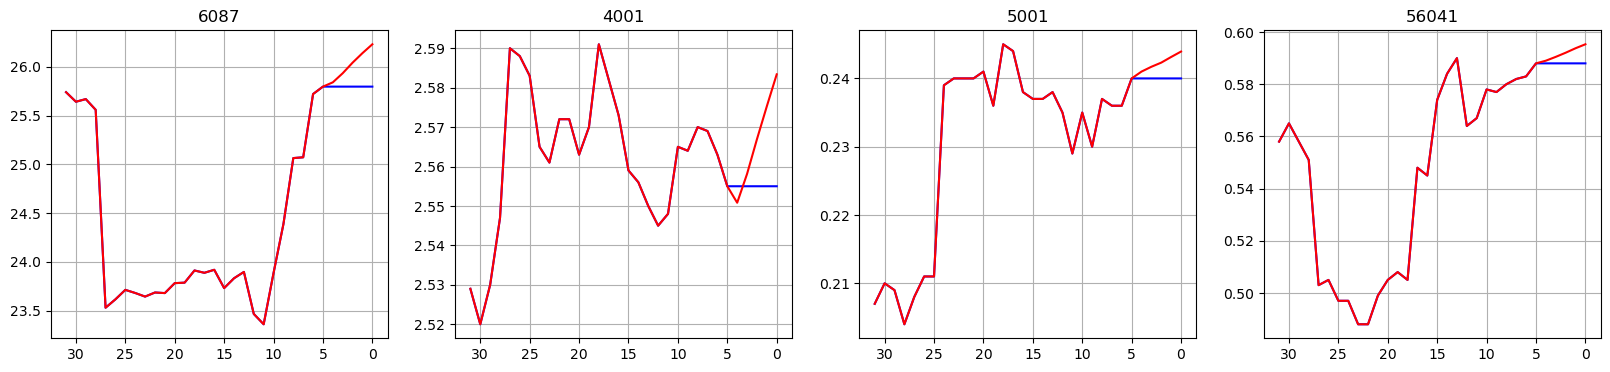

In [38]:
plot_preds_active(test_preds.detach().numpy(), tmp_test_split_df, [6087, 4001, 5001, 56041])

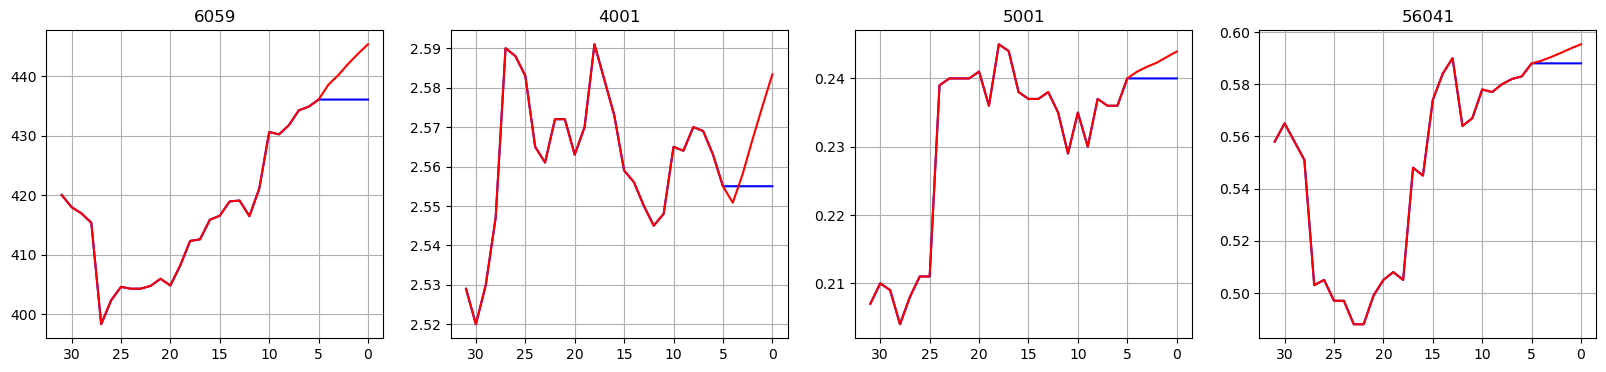

In [39]:
plot_preds_active(test_preds.detach().numpy(), tmp_test_split_df, [6059, 4001, 5001, 56041])

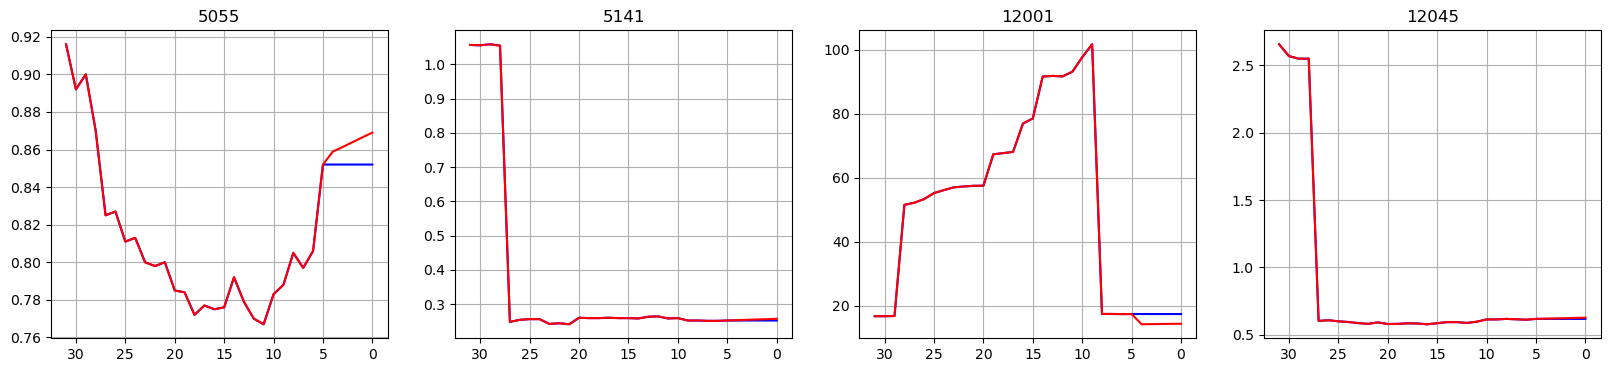

In [40]:
# plot_preds_active(test_preds.detach().numpy(), tmp_test_split_df, [46127, 48063, 48205, 55067])
# plot_preds_active(test_preds.detach().numpy(), tmp_test_split_df, [32510, 38033, 38039, 41023])
# plot_preds_active(test_preds.detach().numpy(), tmp_test_split_df, [28055, 29063, 29171, 31009])
# plot_preds_active(test_preds.detach().numpy(), tmp_test_split_df, [18025, 19143, 19177, 21211,])
plot_preds_active(test_preds.detach().numpy(), tmp_test_split_df, [5055, 5141, 12001, 12045])
# plot_preds_active(test_preds.detach().numpy(), tmp_test_split_df, [13025, 13211, 16077, 17075])

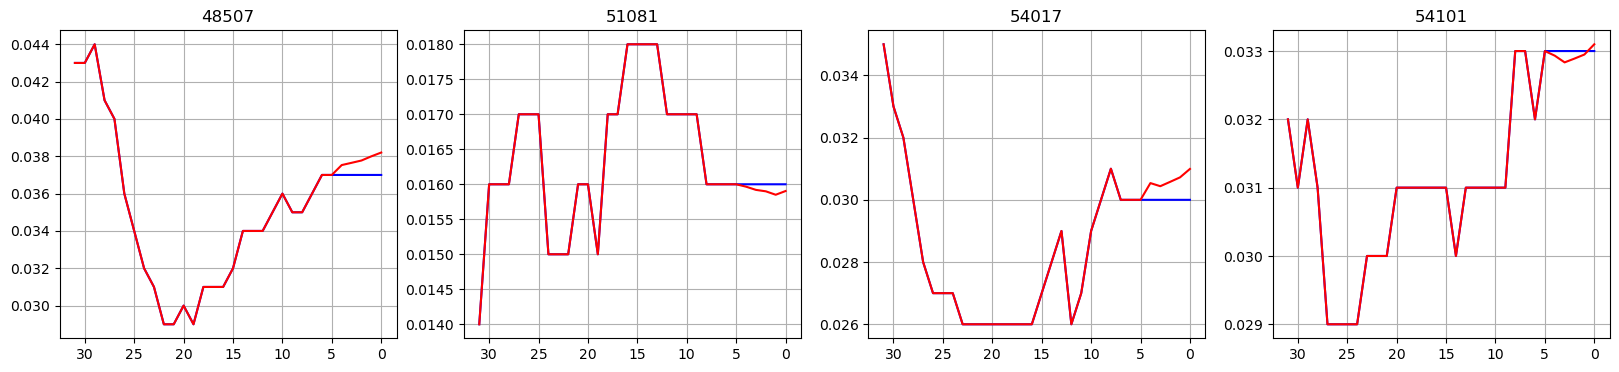

In [42]:
plot_preds_active(test_preds.detach().numpy(), tmp_test_split_df, [48507, 51081, 54017, 54101])